# AI for Medical Diagnosis
Computer Vision (CV) has a lot of applications in medical diagnosis:

* Dermatology
* Ophthakmology
* Histopathology.

X-rays images are critical for the detection of lung cancer, pneumenia ... In this notebook you will learn:

* Data pre-processing
* Preprocess images properly for the train, validation and test sets.
* Set-up a pre-trained neural network to make disease predictions on chest X-rays.

In this notebook you will work with chest X-ray images taken from the public ChestX-ray8 dataset.

# What is Pneumonia ?
From Mayo Clinic's Article on pneumonia

Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia.

Pneumonia can range in seriousness from mild to life-threatening. It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems.


# Computer Vision


Computer vision is an interdisciplinary scientific field that deals with how computers can gain a high-level understanding from digital images or videos. From the perspective of engineering, it seeks to understand and automate tasks that the human visual system can do.
We can use Computer Vision to determine whether a person is affected by pneumonia or not.

#  Import Packages and Functions
We'll make use of the following packages:

* numpy and pandas is what we'll use to manipulate our data
* matplotlib.pyplot and seaborn will be used to produce plots for visualization
* util will provide the locally defined utility functions that have been provided for this assignment
We will also use several modules from the keras framework for building deep learning models.

Run the next cell to import all the necessary packages.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

os.listdir("/content/drive/MyDrive/Projeto_Pneumonia/chest_xray")

['val', 'train', 'chest_xray', '__MACOSX', 'test']

In [3]:
len(os.listdir("/content/drive/MyDrive/Projeto_Pneumonia/chest_xray/train/PNEUMONIA"))

3877

The dataset is divided into three sets: 1) Train set 2) Validation set and 3) Test set.

# Data Visualization


Train set:
PNEUMONIA=3877
NORMAL=1341
Test set:
PNEUMONIA=390
NORMAL=234
Validation set:
PNEUMONIA=8
NORMAL=8


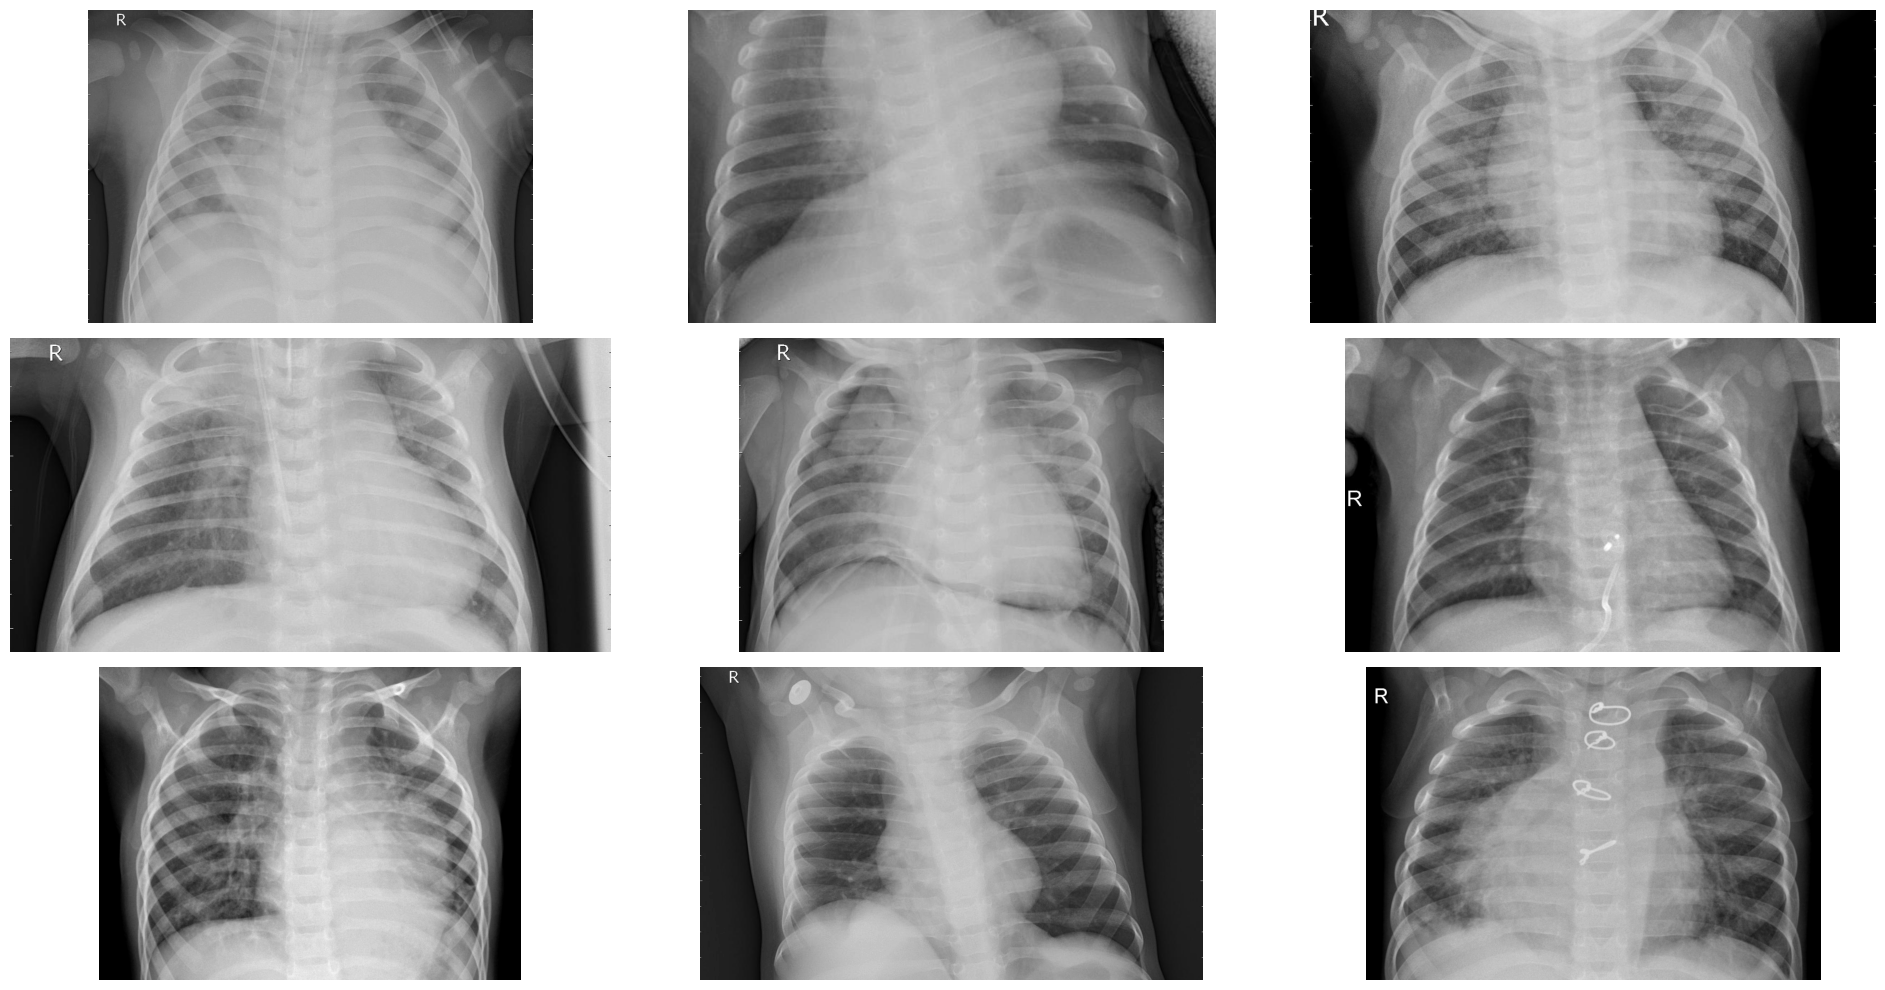

In [4]:
train_dir = "/content/drive/MyDrive/Projeto_Pneumonia/chest_xray/train"
test_dir = "/content/drive/MyDrive/Projeto_Pneumonia/chest_xray/test"
val_dir = "/content/drive/MyDrive/Projeto_Pneumonia/chest_xray/val"

print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("Validation set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

pneumonia = os.listdir("/content/drive/MyDrive/Projeto_Pneumonia/chest_xray/train/PNEUMONIA")
pneumonia_dir = "/content/drive/MyDrive/Projeto_Pneumonia/chest_xray/train/PNEUMONIA"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

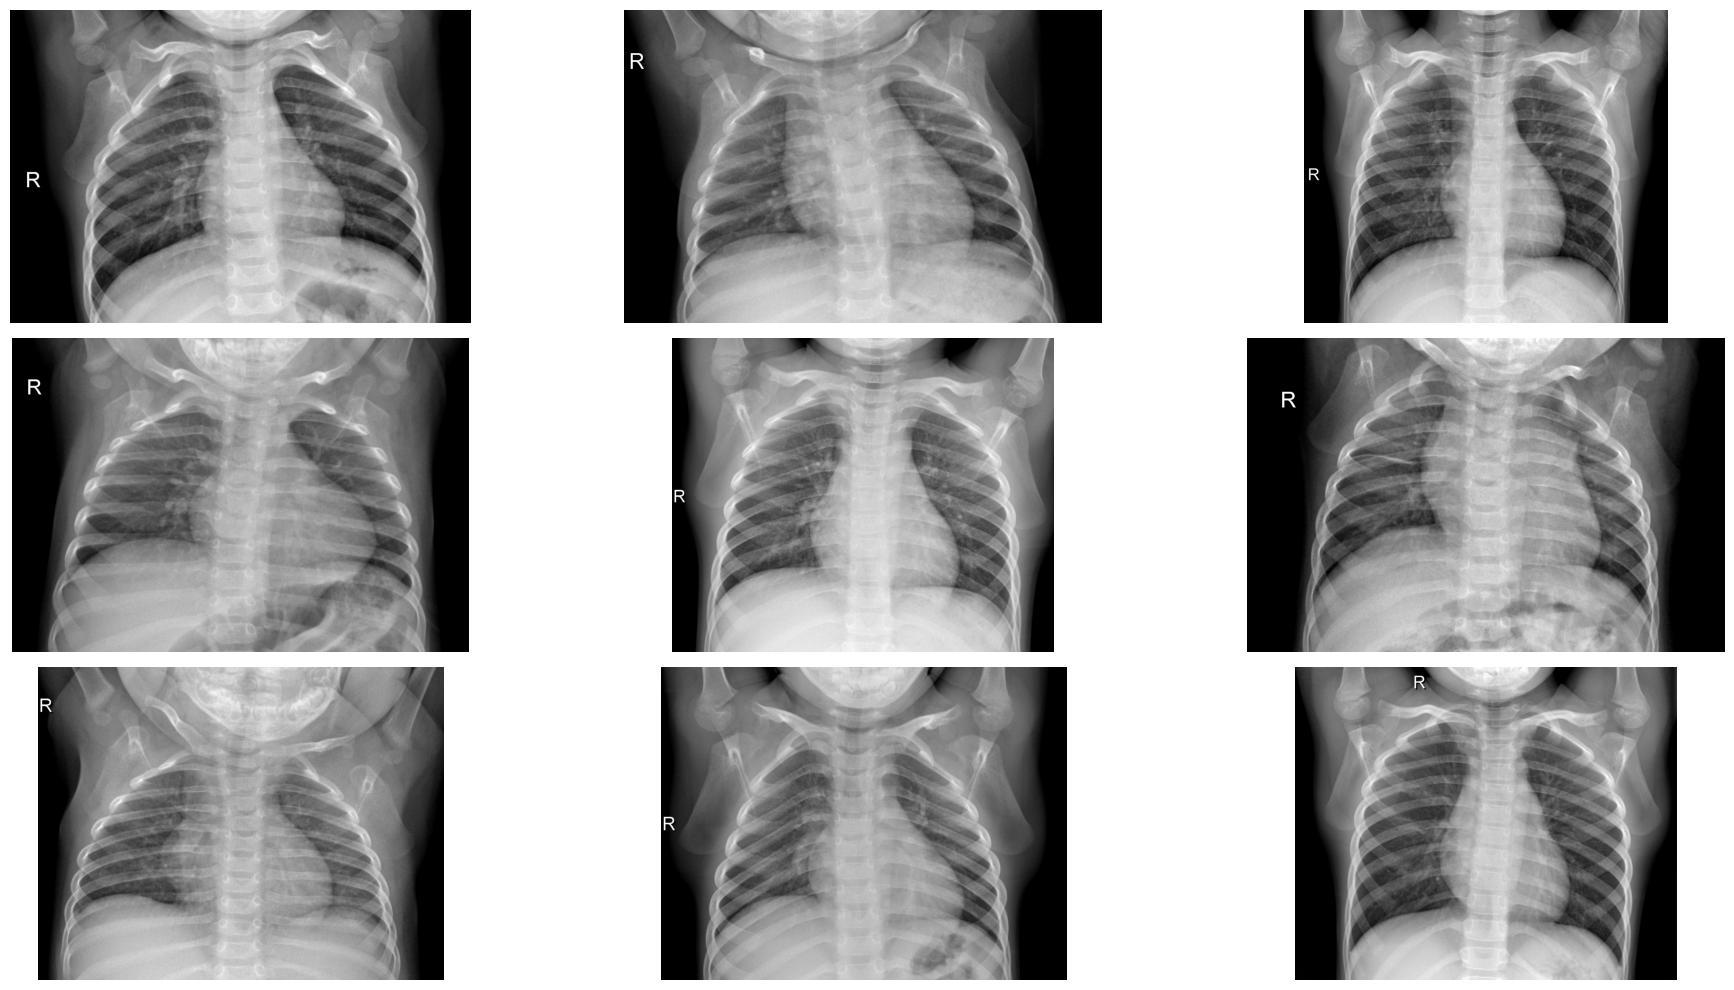

In [5]:
normal = os.listdir("/content/drive/MyDrive/Projeto_Pneumonia/chest_xray/train/NORMAL")
normal_dir = "/content/drive/MyDrive/Projeto_Pneumonia/chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

The dimensions of the image are 1175 pixels width and 1728 pixels height, one single color channel.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 108.3405 and the standard deviation is 67.7860


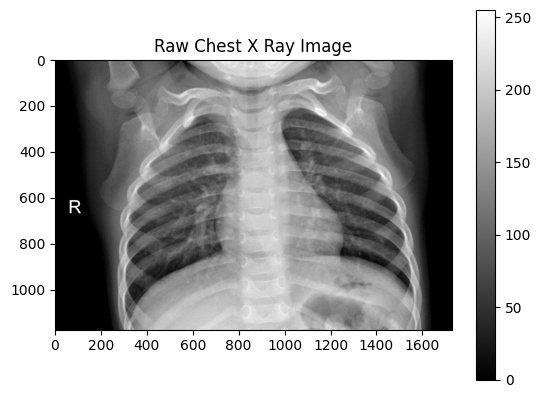

In [6]:
normal_img = os.listdir("/content/drive/MyDrive/Projeto_Pneumonia/chest_xray/train/NORMAL")[0]
normal_dir = "/content/drive/MyDrive/Projeto_Pneumonia/chest_xray/train/NORMAL"
sample_img = plt.imread(os.path.join(normal_dir, normal_img))
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel.")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")

# Ivestigate pixel value distribution

<ipython-input-7-d45ac08d2db9>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_img.ravel(),


Text(0, 0.5, '# Pixels in Image')

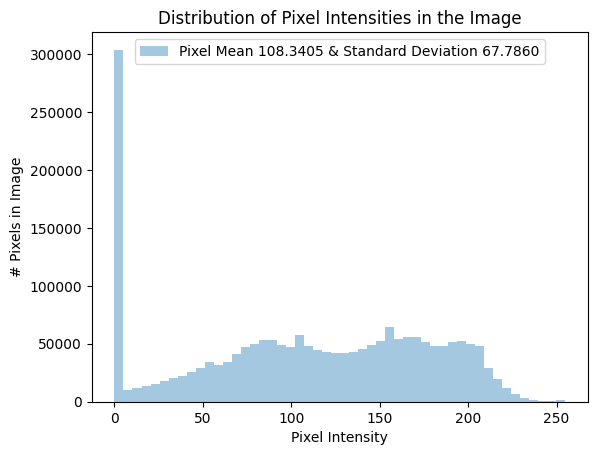

In [7]:
sns.distplot(sample_img.ravel(),
            label=f"Pixel Mean {np.mean(sample_img):.4f} & Standard Deviation {np.std(sample_img):.4f}", kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

# 2. Image Preprocessing
Before training, we'll first modify your images to be better suited for training a convolutional neural network. For this task we'll use the Keras ImageDataGenerator function to perform data preprocessing and data augmentation.

This class also provides support for basic data augmentation such as random horizontal flipping of images.
We also use the generator to transform the values in each batch so that their mean is 0 and their standard deviation is 1 (this will faciliate model training by standardizing the input distribution).
The generator also converts our single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels (we will want this because the pre-trained model that we'll use requires three-channel inputs).

In [8]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

# Build a separate generator fo valid and test sets

Now we need to build a new generator for validation and t esting data.

Why can't use the same generator as for the training data?

Look back at the generator we wrote for the training data.

It normalizes each image per batch, meaning thatit uses batch statistics.
We should not do this with the test and validation data, since in a real life scenario we don't process incoming images a batch at a time (we process one image at a time).
Knowing the average per batch of test data would effectively give our model an advantage (The model should not have any information about the test data).
What we need to do is to normalize incomming test data using the statistics computed from the training set.

In [9]:
train = image_generator.flow_from_directory(train_dir,
                                            batch_size=8,
                                            shuffle=True,
                                            class_mode='binary',
                                            target_size=(180, 180))

validation = image_generator.flow_from_directory(val_dir,
                                                batch_size=1,
                                                shuffle=False,
                                                class_mode='binary',
                                                target_size=(180, 180))

test = image_generator.flow_from_directory(test_dir,
                                            batch_size=1,
                                            shuffle=False,
                                            class_mode='binary',
                                            target_size=(180, 180))

Found 5218 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


The dimensions of the image are 180 pixels width and 180 pixels height, one single color channel.
The maximum pixel value is 2.1983 and the minimum is -3.1173
The mean value of the pixels is -0.0000 and the standard deviation is 1.0000


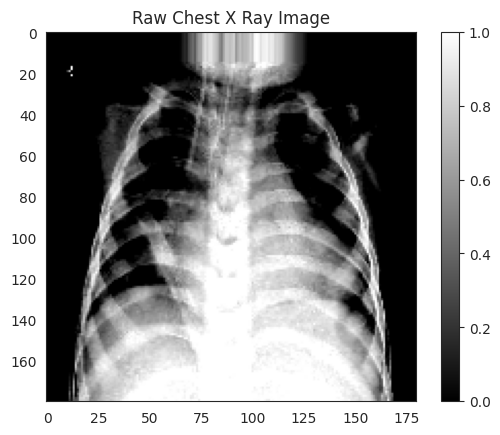

In [10]:
sns.set_style('white')
generated_image, label = train.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

<ipython-input-11-3361fab08a7d>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(generated_image.ravel(),


Text(0, 0.5, '# Pixels in Image')

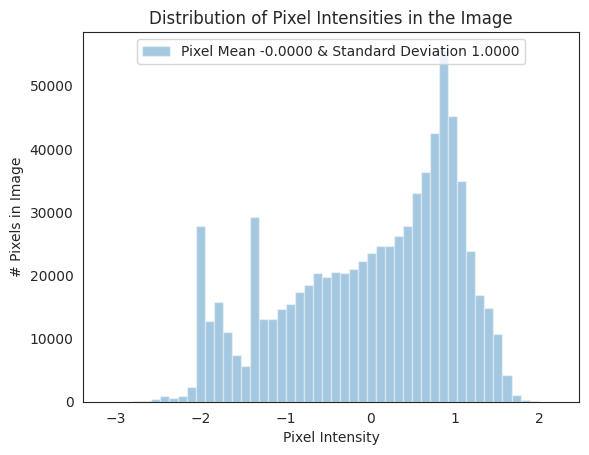

In [11]:
sns.distplot(generated_image.ravel(),
            label=f"Pixel Mean {np.mean(generated_image):.4f} & Standard Deviation {np.std(generated_image):.4f}", kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

# Building a CNN model

## Impact of imbalance data on loss function

Loss Function:
$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

We can rewrite the the overall average cross-entropy loss over the entire training set `D` of size `N` as follows:
$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$



When we have an imbalance data, using a normal loss function will result a model that bias toward the dominating class. One solution is to use a weighted loss function. Using weighted loss function will balance the contribution in the loss function.

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

In [12]:
# Class weights

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.74
Weight for class 1: 0.26


In [15]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall


model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 batch_normalization_12 (Bat  (None, 178, 178, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 176, 176, 32)      9248      
                                                                 
 batch_normalization_13 (Bat  (None, 176, 176, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 88, 88, 32)       0         
 2D)                                                             
                                                      

In [17]:
r = model.fit(
    train,
    epochs=10,
    validation_data=validation,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.9964 - accuracy: 0.7638 - precision: 0.8878 - recall: 0.7691

100/100 [==============================] - 242s 2s/step - loss: 0.9964 - accuracy: 0.7638 - precision: 0.8878 - recall: 0.7691 - val_loss: 11.6275 - val_accuracy: 0.5625 - val_precision: 0.5333 - val_recall: 1.0000
Epoch 2/10
100/100 [==============================] - 227s 2s/step - loss: 0.2495 - accuracy: 0.8401 - precision: 0.9537 - recall: 0.8275
Epoch 3/10
100/100 [==============================] - 229s 2s/step - loss: 0.2489 - accuracy: 0.8388 - precision: 0.9433 - recall: 0.8344
Epoch 4/10
100/100 [==============================] - 264s 3s/step - loss: 0.1756 - accuracy: 0.8575 - precision: 0.9604 - recall: 0.8455
Epoch 5/10
100/100 [==============================] - 230s 2s/step - loss: 0.1231 - accuracy: 0.8463 - precision: 0.9688 - recall: 0.8242
Epoch 6/10
100/100 [==============================] - 233s 2s/step - loss: 0.1170 - accuracy: 0.8725 - precision: 0.9672 - recall: 0.8549
Epoch 7/10
100/100 [==============================] - 230s 2s/step - loss: 0.1086 - accuracy: 0

Text(0.5, 1.0, 'Accuracy Evolution')

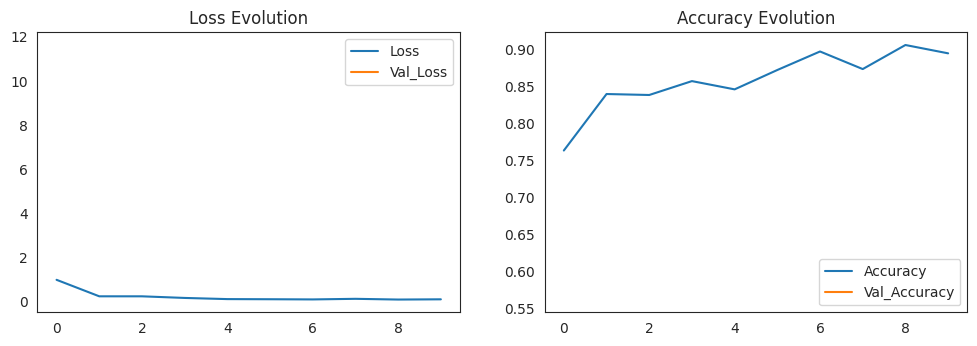

In [18]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [19]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 59s 95ms/step - loss: 0.9496 - accuracy: 0.7404 - precision: 0.7080 - recall: 0.9949
Test Accuracy: 74.04%
653/653 [==============================] - 395s 604ms/step - loss: 0.2930 - accuracy: 0.9086 - precision: 0.9019 - recall: 0.9840
Train Accuracy: 90.86%


In [20]:
from sklearn.metrics import confusion_matrix, classification_report

pred = model.predict(test)

print(confusion_matrix(test.classes, pred > 0.5))
pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True))

624/624 [==============================] - 53s 85ms/step
[[ 74 160]
 [  3 387]]


,0,1,accuracy,macro avg,weighted avg
precision,0.961039,0.707495,0.738782,0.834267,0.802574
recall,0.316239,0.992308,0.738782,0.654274,0.738782
f1-score,0.475884,0.826041,0.738782,0.650962,0.694732
support,234.000000,390.000000,0.738782,624.000000,624.000000


In [21]:
print(confusion_matrix(test.classes, pred > 0.7))
pd.DataFrame(classification_report(test.classes, pred > 0.7, output_dict=True))

[[ 98 136]
 [  5 385]]


,0,1,accuracy,macro avg,weighted avg
precision,0.951456,0.738964,0.774038,0.845210,0.818648
recall,0.418803,0.987179,0.774038,0.702991,0.774038
f1-score,0.581602,0.845225,0.774038,0.713414,0.746367
support,234.000000,390.000000,0.774038,624.000000,624.000000


In [28]:
# Avaliação das métricas no conjunto de treinamento
evaluation_train_custom_cnn = model.evaluate(train)

# Métricas do conjunto de treinamento
loss_train_custom_cnn = evaluation_train_custom_cnn[0]
accuracy_train_custom_cnn = evaluation_train_custom_cnn[1]
precision_train_custom_cnn = evaluation_train_custom_cnn[2]
recall_train_custom_cnn = evaluation_train_custom_cnn[3]

# Cálculo do F1 Score manualmente no conjunto de treinamento
f1_score_train_custom_cnn = 2 * (precision_train_custom_cnn * recall_train_custom_cnn) / (precision_train_custom_cnn + recall_train_custom_cnn)

print("CNN Personalizada (Treinamento):")
print(f"Train Loss (Custom CNN): {loss_train_custom_cnn:.4f}")
print(f"Train Accuracy (Custom CNN): {accuracy_train_custom_cnn * 100:.2f}%")
print(f"Train Precision (Custom CNN): {precision_train_custom_cnn * 100:.2f}%")
print(f"Train Recall (Custom CNN): {recall_train_custom_cnn * 100:.2f}%")
print(f"Train F1 Score (Custom CNN): {f1_score_train_custom_cnn * 100:.2f}%")

653/653 [==============================] - 398s 609ms/step - loss: 0.2829 - accuracy: 0.9090 - precision: 0.9016 - recall: 0.9850
CNN Personalizada (Treinamento):
Train Loss (Custom CNN): 0.2829
Train Accuracy (Custom CNN): 90.90%
Train Precision (Custom CNN): 90.16%
Train Recall (Custom CNN): 98.50%
Train F1 Score (Custom CNN): 94.15%


In [22]:
from sklearn.metrics import classification_report

# Depois de treinar o modelo
evaluation = model.evaluate(test)
print(f"Test Accuracy (Custom CNN): {evaluation[1] * 100:.2f}%")

# Realizar previsões no conjunto de teste
predictions = model.predict(test)
predicted_classes = (predictions > 0.5).astype(int)

# Obter rótulos verdadeiros do conjunto de teste
true_labels = test.classes

# Calcular F1-score, precisão e recall
report = classification_report(true_labels, predicted_classes, target_names=['NORMAL', 'PNEUMONIA'])
print(report)


624/624 [==============================] - 55s 87ms/step - loss: 0.9675 - accuracy: 0.7212 - precision: 0.6949 - recall: 0.9872
Test Accuracy (Custom CNN): 72.12%
624/624 [==============================] - 54s 87ms/step
              precision    recall  f1-score   support

      NORMAL       0.96      0.30      0.46       234
   PNEUMONIA       0.70      0.99      0.82       390

    accuracy                           0.73       624
   macro avg       0.83      0.65      0.64       624
weighted avg       0.80      0.73      0.69       624



In [23]:
evaluation_custom_cnn = model.evaluate(test)
loss_custom_cnn = evaluation_custom_cnn[0]
accuracy_custom_cnn = evaluation_custom_cnn[1]
precision_custom_cnn = evaluation_custom_cnn[2]
recall_custom_cnn = evaluation_custom_cnn[3]

# Calcular o F1 Score manualmente
f1_score_custom_cnn = 2 * (precision_custom_cnn * recall_custom_cnn) / (precision_custom_cnn + recall_custom_cnn)

print(f"Test Loss (Custom CNN): {loss_custom_cnn:.4f}")
print(f"Test Accuracy (Custom CNN): {accuracy_custom_cnn * 100:.2f}%")
print(f"Test Precision (Custom CNN): {precision_custom_cnn * 100:.2f}%")
print(f"Test Recall (Custom CNN): {recall_custom_cnn * 100:.2f}%")
print(f"Test F1 Score (Custom CNN): {f1_score_custom_cnn * 100:.2f}%")


624/624 [==============================] - 55s 88ms/step - loss: 0.9045 - accuracy: 0.7324 - precision: 0.7024 - recall: 0.9923
Test Loss (Custom CNN): 0.9045
Test Accuracy (Custom CNN): 73.24%
Test Precision (Custom CNN): 70.24%
Test Recall (Custom CNN): 99.23%
Test F1 Score (Custom CNN): 82.25%


# ResNet

See the full explanation and schemes in the Research Paper on Deep Residual Learning (https://arxiv.org/pdf/1512.03385.pdf)

In [24]:
from keras.applications import ResNet50

resnet_base_model = ResNet50(input_shape=(180,180,3), include_top=False, weights='imagenet')



In [25]:
resnet_base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1_conv[0][0]']      

In [26]:
from keras.layers import GlobalAveragePooling2D

In [30]:
    resnet_model = tf.keras.Sequential([
        resnet_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1,activation="sigmoid")
    ])

    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
    ]
    resnet_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=METRICS)

In [31]:
r = resnet_model.fit(train,
          epochs=10,
          validation_data=validation,
          class_weight=class_weight,
          steps_per_epoch=100,
          validation_steps=25)


Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.3003 - accuracy: 0.5888 - precision: 0.8284 - recall: 0.5616

100/100 [==============================] - 507s 5s/step - loss: 0.3003 - accuracy: 0.5888 - precision: 0.8284 - recall: 0.5616 - val_loss: 87.1841 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/10
100/100 [==============================] - 475s 5s/step - loss: 0.3015 - accuracy: 0.5800 - precision: 0.8193 - recall: 0.5572
Epoch 3/10
100/100 [==============================] - 475s 5s/step - loss: 0.2923 - accuracy: 0.5738 - precision: 0.7978 - recall: 0.5967
Epoch 4/10
100/100 [==============================] - 479s 5s/step - loss: 0.2602 - accuracy: 0.6225 - precision: 0.8582 - recall: 0.5950
Epoch 5/10
100/100 [==============================] - 472s 5s/step - loss: 0.2219 - accuracy: 0.6975 - precision: 0.8982 - recall: 0.6684
Epoch 6/10
100/100 [==============================] - 473s 5s/step - loss: 0.2050 - accuracy: 0.7063 - precision: 0.9130 - recall: 0.6695
Epoch 7/10
100/100 [==============================] - 471s 5s/step - loss: 0.2284 - accuracy: 0

Text(0.5, 1.0, 'Accuracy Evolution')

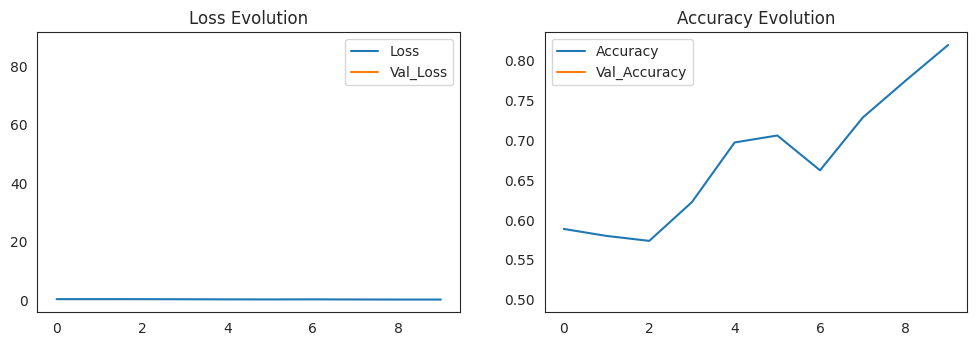

In [32]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [33]:
evaluation =resnet_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = resnet_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 112s 179ms/step - loss: 0.4833 - accuracy: 0.7965 - precision: 0.7840 - recall: 0.9308
Test Accuracy: 79.65%
653/653 [==============================] - 744s 1s/step - loss: 0.3760 - accuracy: 0.9105 - precision: 0.9559 - recall: 0.9221
Train Accuracy: 91.05%
